In [ ]:
import geopandas as gpd
import numpy as np
from pathlib import Path
from IPython.core.debugger import set_trace
from shapely import box
import pandas as pd
from geograypher.utils.geospatial import ensure_non_overlapping_polygons
from geograypher.utils.geospatial import ensure_projected_CRS

In [110]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions")

# Corresponding to <> site
# Quail
ROI = box(xmin=-122.5, ymin=38, xmax=-122, ymax=39)
# BORR
#ROI = box(xmin=-122, ymin=37, xmax=-121.5, ymax=38)
# Hast
# ROI = box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)

ENSURE_NONOVERLAPPING = False

In [ ]:
def plot_map(gdf):
    gdf.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)

In [112]:
metadata = gpd.read_file(METADATA_FILE)
metadata = metadata[["mission_id", "earliest_year_derived"]]
metadata

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


,mission_id,earliest_year_derived
0,000421,2019.0
1,000422,2019.0
2,000423,2019.0
3,000424,2019.0
4,000425,2019.0
...,...,...
414,000927,2024.0
415,000928,2024.0
416,000929,2024.0
417,000930,2024.0


In [113]:
pred_files = sorted(PREDS_FOLDER.glob("*"))

In [114]:
metadata_2020 = metadata[metadata["earliest_year_derived"] == 2020]

<Axes: >

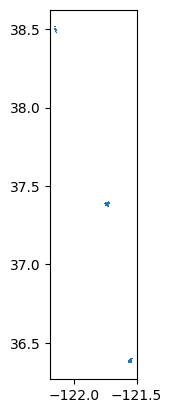

In [115]:
preds = []

for pred_file in pred_files:
    pred = gpd.read_file(pred_file)
    pred["mission_id"] = pred_file.stem
    if pred_file.stem == "000559":
        # Weird individual polygon one
        # TODO figure out what's going on here
        continue

    preds.append(pred)

all_preds = pd.concat(preds)
all_preds.plot()

In [116]:
merged = all_preds.merge(metadata, on="mission_id")
merged = merged.clip(ROI)

merged_2020 = merged[merged["earliest_year_derived"] == 2020]
merged_2023 = merged[merged["earliest_year_derived"] == 2023]
merged_2024 = merged[merged["earliest_year_derived"] == 2024]

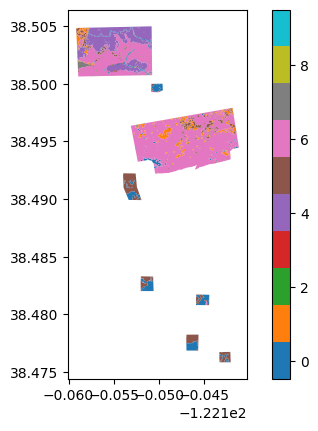

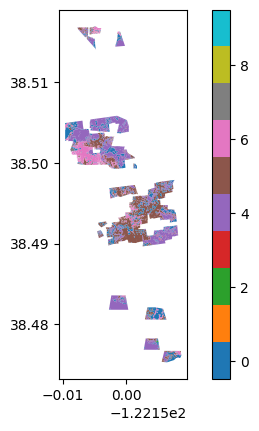

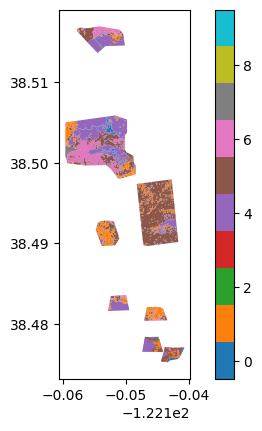

In [117]:
plot_map(merged_2020)
plot_map(merged_2023)
plot_map(merged_2024)

In [118]:
dissolved_2020 = merged_2020.dissolve(by="class_names", as_index=False)
dissolved_2023 = merged_2023.dissolve(by="class_names", as_index=False)
dissolved_2024 = merged_2024.dissolve(by="class_names", as_index=False)

<Axes: >

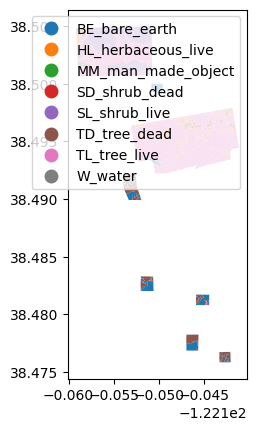

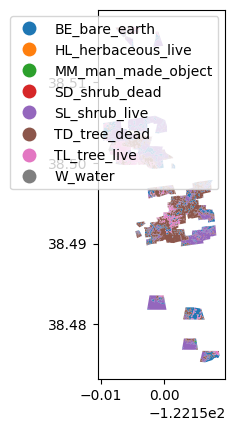

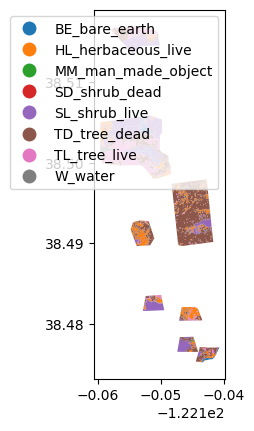

In [119]:
dissolved_2020.plot("class_names", vmin=-0.5, vmax=9.5, legend=True)
dissolved_2023.plot("class_names", vmin=-0.5, vmax=9.5, legend=True)
dissolved_2024.plot("class_names", vmin=-0.5, vmax=9.5, legend=True)

In [120]:
boundary_2020 = dissolved_2020.dissolve()
boundary_2023 = dissolved_2023.dissolve()
boundary_2024 = dissolved_2024.dissolve()

In [121]:
shared_region = boundary_2020.intersection(boundary_2023).intersection(boundary_2024).geometry[0]

In [122]:
subset_2020 = dissolved_2020.clip(shared_region)
subset_2023 = dissolved_2023.clip(shared_region)
subset_2024 = dissolved_2024.clip(shared_region)

In [123]:
if ENSURE_NONOVERLAPPING:
    subset_2020 = ensure_non_overlapping_polygons(subset_2020)
    print("non-overlapping for 2020")
    subset_2023 = ensure_non_overlapping_polygons(subset_2023)
    print("non-overlapping for 2020")
    subset_2024 = ensure_non_overlapping_polygons(subset_2024)
    print("non-overlapping for 2020")

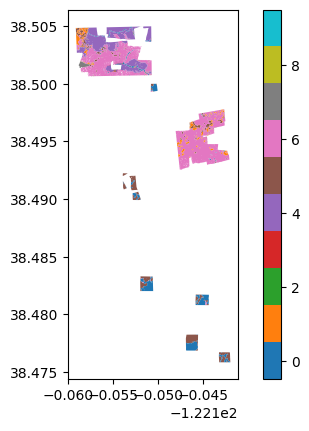

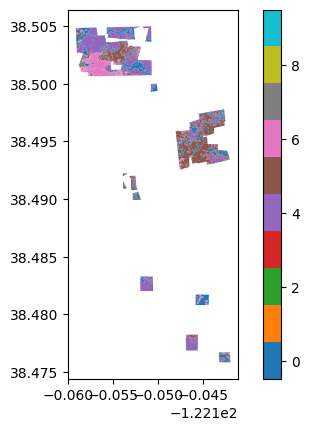

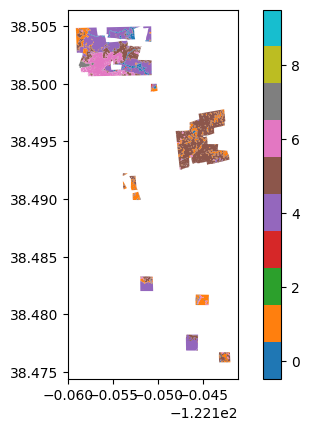

In [124]:
plot_map(subset_2020)
plot_map(subset_2023)
plot_map(subset_2024)

In [125]:
subset_2020 = ensure_projected_CRS(subset_2020)
subset_2023 = ensure_projected_CRS(subset_2023)
subset_2024 = ensure_projected_CRS(subset_2024)

subset_2020["area"] = subset_2020.area / subset_2020.area.sum()
subset_2023["area"] = subset_2023.area / subset_2023.area.sum()
subset_2024["area"] = subset_2024.area / subset_2024.area.sum()

In [126]:
subset_2020.sort_index()

,class_names,geometry,class_ID,mission_id,earliest_year_derived,area
0,BE_bare_earth,"MULTIPOLYGON (((573469.368 4261705.549, 573469...",0.0,000583,2020.0,0.097669
1,HL_herbaceous_live,"MULTIPOLYGON (((573381.458 4261784.257, 573381...",1.0,000585,2020.0,0.045389
2,MM_man_made_object,"MULTIPOLYGON (((573658.219 4261812.087, 573658...",2.0,000584,2020.0,0.000213
3,SD_shrub_dead,"MULTIPOLYGON (((573404.142 4261988.184, 573404...",3.0,000580,2020.0,0.000085
4,SL_shrub_live,GEOMETRYCOLLECTION (POLYGON ((573381.970 42618...,4.0,000579,2020.0,0.183221
5,TD_tree_dead,"MULTIPOLYGON (((573384.968 4261746.370, 573386...",5.0,000583,2020.0,0.139345
6,TL_tree_live,"MULTIPOLYGON (((573384.886 4261787.031, 573384...",6.0,000585,2020.0,0.527059
7,W_water,"MULTIPOLYGON (((574529.306 4261185.244, 574529...",7.0,000579,2020.0,0.007019


In [127]:
subset_2023.sort_index()

,class_names,geometry,class_ID,mission_id,earliest_year_derived,area
0,BE_bare_earth,"MULTIPOLYGON (((573453.884 4261708.045, 573453...",0.0,000620,2023.0,0.212751
1,HL_herbaceous_live,"MULTIPOLYGON (((573396.149 4261786.674, 573396...",1.0,000627,2023.0,0.000106
2,MM_man_made_object,"MULTIPOLYGON (((574513.747 4259546.968, 574512...",2.0,000619,2023.0,0.000118
3,SD_shrub_dead,"MULTIPOLYGON (((573526.639 4261859.422, 573526...",3.0,000620,2023.0,0.008687
4,SL_shrub_live,GEOMETRYCOLLECTION (POLYGON ((573525.077 42618...,4.0,000620,2023.0,0.375592
5,TD_tree_dead,"MULTIPOLYGON (((573481.422 4261703.744, 573481...",5.0,000620,2023.0,0.300373
6,TL_tree_live,"MULTIPOLYGON (((573468.517 4261704.567, 573468...",6.0,000622,2023.0,0.098303
7,W_water,"POLYGON ((573357.740 4261829.628, 573358.462 4...",7.0,000627,2023.0,0.004071


In [128]:
subset_2024.sort_index()

,class_names,geometry,class_ID,mission_id,earliest_year_derived,area
0,BE_bare_earth,GEOMETRYCOLLECTION (POLYGON ((573676.656 42617...,0.0,000927,2024.0,0.041442
1,HL_herbaceous_live,GEOMETRYCOLLECTION (POLYGON ((573393.704 42617...,1.0,000927,2024.0,0.149315
2,MM_man_made_object,"MULTIPOLYGON (((574512.215 4259547.544, 574512...",2.0,000928,2024.0,0.000018
3,SD_shrub_dead,"MULTIPOLYGON (((573621.042 4261732.815, 573620...",3.0,000927,2024.0,0.004804
4,SL_shrub_live,"MULTIPOLYGON (((573432.449 4261857.258, 573432...",4.0,000927,2024.0,0.274700
5,TD_tree_dead,"MULTIPOLYGON (((573452.867 4261717.034, 573453...",5.0,000927,2024.0,0.400892
6,TL_tree_live,"MULTIPOLYGON (((573478.700 4261706.786, 573478...",6.0,000930,2024.0,0.120122
7,W_water,"MULTIPOLYGON (((573362.721 4261841.001, 573363...",7.0,000921,2024.0,0.008706


In [ ]:
final_table = np.zeros((8,3))
final_table[subset_2020["class_ID"].to_numpy().astype(int), 0] = subset_2020["area"]
final_table[subset_2023["class_ID"].to_numpy().astype(int), 1] = subset_2023["area"]
final_table[subset_2024["class_ID"].to_numpy().astype(int), 2] = subset_2024["area"]

In [143]:
final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"])
final_table_vis

,2020,2023,2024
Bare Earth,0.097669,0.212751,0.041442
Herbaceous Live,0.045389,0.000106,0.149315
Man Made,0.000213,0.000118,0.000018
Shrub Dead,0.000085,0.008687,0.004804
Shrub Live,0.183221,0.375592,0.274700
Tree Dead,0.139345,0.300373,0.400892
Tree Live,0.527059,0.098303,0.120122
Water,0.007019,0.004071,0.008706
